In [4]:
from pathlib import Path
import pandas as pd

root = Path.cwd().parent
# The purpose of this line is to make sure we get the root of the project
# as Path.cwd() gives the current working folder, and we are getting the root 
# so that we can access the train.csv file in the data folder efficiently

train_path = root / "data" / "train.csv"

print("Reading:", train_path.resolve())
df = pd.read_csv(train_path)
print(df.head())
print("Shape:", df.shape)

Reading: /Users/krithiktoure/Desktop/DS Project 1/data/train.csv
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        1         0.999812   13380276.64        NaN   
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target  \
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704 

In [ ]:
TARGET = "target"

df_clean = df.copy()

expected_numeric = [                      
    "stock_id","date_id","seconds_in_bucket",
    "imbalance_size","imbalance_buy_sell_flag",
    "reference_price","matched_size",
    "far_price","near_price",
    "bid_price","bid_size","ask_price","ask_size",
    "wap", TARGET
    ]

# This for loop iterates through the expected_numeric column list
# and converts the columns in the copied dataframe to numeric type
# The error parameter is set to 'coerce' to handle any non-numeric values
# that cannot be converted to numeric type by setting them to NaN
for col in expected_numeric:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors ='coerce')

# You cannot train supervised models without a target row, so we drop ROWS
# that have NaN in the target column

if TARGET in df_clean.columns:
    df_clean_before = len(df_clean)
    df_clean = df_clean.dropna(subset=TARGET)
    df_clean_after = len(df_clean)
    print(f"Dropped {df_clean_before - df_clean_after} rows with NaN in target column")
else:
    print(f"Warning: Target column '{TARGET}' not found in dataframe")

# This again has the for loop c for c that puts the values into the list
# and it will add all the numeric columns so that all the NaN values
# are replaced with 0

for col in expected_numeric:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(0)

# Sizes should not have any values below 0, so we replace any negative values with 0
# The last line "clips" the values to be at least 0
for c in ["imbalance_size","matched_size","bid_size","ask_size"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].clip(lower=0)

#This for loop adds the columns that represent the date, stock id, and seconds
# to the list if they are present in the dataframe
sort_cols = [c for c in ['date_id', 'stock_id', 'seconds_in_bucket'] if c in df_clean.columns]

if sort_cols:
    df_clean = df_clean.sort_values(by=sort_cols).reset_index(drop=True)


print("Cleaned Shape: ", df_clean.shape)
display(df_clean.head())
print(df_clean.isna().sum())

Dropped 88 rows with NaN in target column
Cleaned Shape:  (5237892, 17)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,0,0,10,1299772.70,1,1.000026,15261106.63,0.0,0.0,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
2,0,0,20,1299772.70,1,0.999919,15261106.63,0.0,0.0,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
3,0,0,30,1299772.70,1,1.000133,15261106.63,0.0,0.0,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
4,0,0,40,1218204.43,1,1.000455,15342674.90,0.0,0.0,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0


In [10]:
import pandas as pd

df_feat = df_clean.copy()

#Bid-Ask Spread
df_feat['bid_ask_spread'] = df_feat['ask_price'] - df_feat['bid_price']

#Mid Price
df_feat['mid_price'] = (df_feat['bid_price'] + df_feat['ask_price']) / 2

#Signed Imbalance
df_feat['signed_imbalance'] = df_feat['imbalance_size'] * df_feat['imbalance_buy_sell_flag']

#Near/Far Minus Reference Price - how far auction prices are from the reference price
for c in ["near_price", "far_price"]:
    new_col = f"{c}_minus_ref"
    if {c, "reference_price"}.issubset(df_feat.columns):
        df_feat[new_col] = df_feat[c] - df_feat["reference_price"]
    else:
        df_feat[new_col] = 0.0

if "seconds_in_bucket" in df_feat.columns:
    sib = df_feat["seconds_in_bucket"]
    df_feat["sec_bucket_group"] = (
        (sib >= 300).astype("int8") + (sib >= 480).astype("int8")
    ).astype("int8")
else:
    df_feat["sec_bucket_group"] = 0

FEATURES = [
    col for col in [
        "seconds_in_bucket",          # where in the auction window we are
        "sec_bucket_group",           # early/middle/late (0/1/2)
        "bid_ask_spread", "mid_price",
        "signed_imbalance",
        "near_price_minus_ref", "far_price_minus_ref",
        "matched_size", "imbalance_size", "bid_size", "ask_size",
        "reference_price", "wap"
    ] if col in df_feat.columns
]

print("Using features:", FEATURES)

target_col = "target" if "target" in df_feat.columns else None
cols_to_show = FEATURES + ([target_col] if target_col else [])
display(df_feat[cols_to_show].head(5))


Using features: ['seconds_in_bucket', 'sec_bucket_group', 'bid_ask_spread', 'mid_price', 'signed_imbalance', 'near_price_minus_ref', 'far_price_minus_ref', 'matched_size', 'imbalance_size', 'bid_size', 'ask_size', 'reference_price', 'wap']


,seconds_in_bucket,sec_bucket_group,bid_ask_spread,mid_price,signed_imbalance,near_price_minus_ref,far_price_minus_ref,matched_size,imbalance_size,bid_size,ask_size,reference_price,wap,target
0,0,0,0.000214,0.999919,3180602.69,-0.999812,-0.999812,13380276.64,3180602.69,60651.50,8493.03,0.999812,1.000000,-3.029704
1,10,0,0.000214,0.999919,1299772.70,-1.000026,-1.000026,15261106.63,1299772.70,13996.50,23519.16,1.000026,0.999892,0.389814
2,20,0,0.000107,0.999866,1299772.70,-0.999919,-0.999919,15261106.63,1299772.70,4665.50,12131.60,0.999919,0.999842,4.220009
3,30,0,0.000107,1.000080,1299772.70,-1.000133,-1.000133,15261106.63,1299772.70,55998.00,46203.30,1.000133,1.000085,5.450249
4,40,0,0.000214,1.000348,1218204.43,-1.000455,-1.000455,15342674.90,1218204.43,14655.95,26610.45,1.000455,1.000317,3.169775


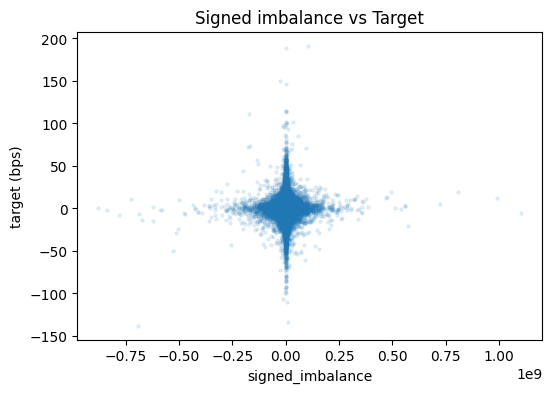

In [13]:
import numpy as np
import matplotlib.pyplot as plt

cols_needed = {"signed_imbalance", "target"}

if not cols_needed.issubset(df_feat.columns):
    print("Error: Required columns are missing from the dataframe.")
else:
    tiny = df_feat[["signed_imbalance", "target"]].dropna()

n = min(100000, len(tiny))
sample = tiny.sample(n=n, random_state=42)

plt.figure(figsize=(6, 4))

plt.scatter(sample["signed_imbalance"], sample["target"], s=5, alpha=0.1)

plt.xlabel("signed_imbalance")
plt.ylabel("target (bps)")
plt.title("Signed imbalance vs Target")
plt.show()


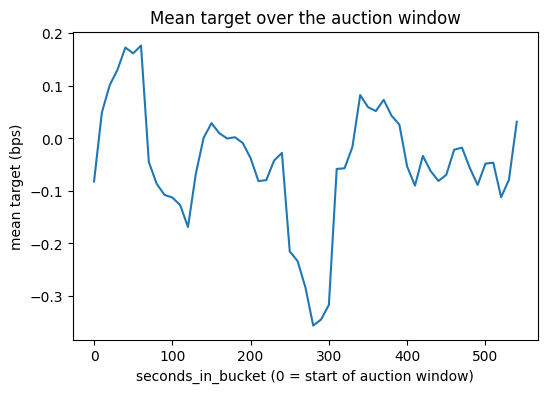

In [14]:
import pandas as pd                
import matplotlib.pyplot as plt  

needed = {"seconds_in_bucket", "target"}
if not needed.issubset(df_feat.columns):
    print("Missing one of:", needed, "— make sure Cells 2 and 3 ran, and that 'target' is present.")
else:
    # Group rows that have the same seconds_in_bucket and compute the average target for each second
    mean_by_sec = (
        df_feat[["seconds_in_bucket", "target"]]
        .dropna()
        .groupby("seconds_in_bucket", observed=True)["target"]
        .mean()
        .sort_index()
    )

    plt.figure(figsize=(6, 4))

    plt.plot(mean_by_sec.index.values, mean_by_sec.values)

    plt.xlabel("seconds_in_bucket (0 = start of auction window)")
    plt.ylabel("mean target (bps)")
    plt.title("Mean target over the auction window")
    plt.show()

In [26]:
import sys, importlib
from pathlib import Path

ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import src.clean as clean
importlib.reload(clean)      # ensure latest version
from src.clean import basic_clean

df_clean_lib = basic_clean(df, impute="median")
print("Cleaned shape (library):", df_clean_lib.shape)
display(df_clean_lib.head(3))

Cleaned shape (library): (5237892, 17)


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999883,0.999889,0.999812,60651.5,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,0,0,10,1299772.70,1,1.000026,15261106.63,0.999883,0.999889,0.999812,13996.5,1.000026,23519.16,0.999892,0.389814,1,0_10_0
2,0,0,20,1299772.70,1,0.999919,15261106.63,0.999883,0.999889,0.999812,4665.5,0.999919,12131.60,0.999842,4.220009,2,0_20_0


In [27]:
import sys, importlib
from pathlib import Path

ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import src.features as features
importlib.reload(features)

df_feat_lib, FEATURES = features.build_min_features(df_clean_lib, include_bucket=True)
print("Num features:", len(FEATURES))
print("FEATURES:", FEATURES)
display(df_feat_lib[FEATURES + (["target"] if "target" in df_feat_lib.columns else [])].head(3))


Num features: 13
FEATURES: ['seconds_in_bucket', 'sec_bucket_group', 'bid_ask_spread', 'mid_price', 'signed_imbalance', 'near_price_minus_ref', 'far_price_minus_ref', 'matched_size', 'imbalance_size', 'bid_size', 'ask_size', 'reference_price', 'wap']


,seconds_in_bucket,sec_bucket_group,bid_ask_spread,mid_price,signed_imbalance,near_price_minus_ref,far_price_minus_ref,matched_size,imbalance_size,bid_size,ask_size,reference_price,wap,target
0,0,0,0.000214,0.999919,3180602.69,0.000077,0.000071,13380276.64,3180602.69,60651.5,8493.03,0.999812,1.000000,-3.029704
1,10,0,0.000214,0.999919,1299772.70,-0.000137,-0.000143,15261106.63,1299772.70,13996.5,23519.16,1.000026,0.999892,0.389814
2,20,0,0.000107,0.999866,1299772.70,-0.000030,-0.000036,15261106.63,1299772.70,4665.5,12131.60,0.999919,0.999842,4.220009
